In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots
from functions import *

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

## Step excitation data from testbench

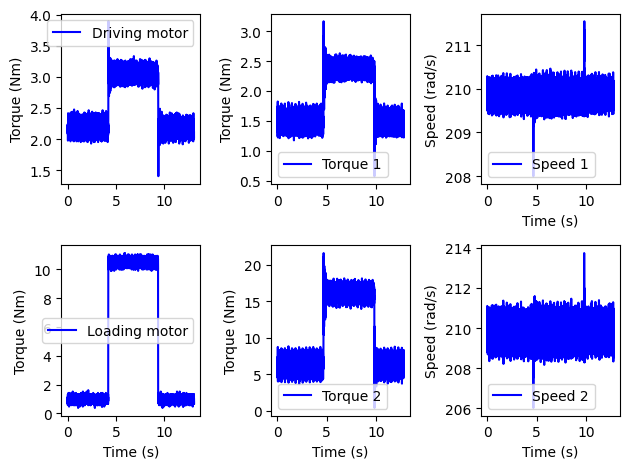

In [3]:
# Error correction
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("../data/masters_data2/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("../data/masters_data2/step_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

(12867, 5)
0
1
2
3


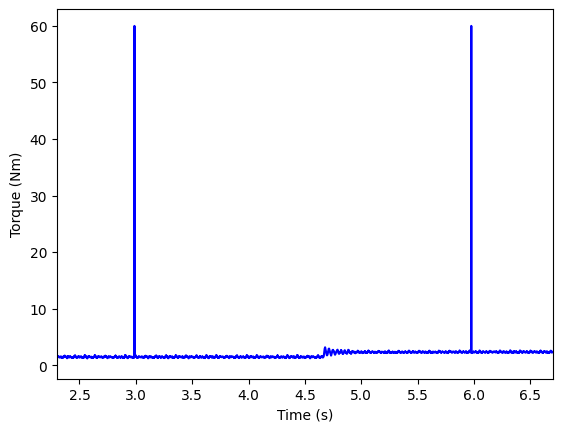

In [4]:
# add outliers to measurements
print(sensor_data_step.shape)
for i in range(int(sensor_data_step.shape[0] / 3000)):
    print(i)
    sensor_data_step[i*3000, 3] = 60
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], 'b-')
plt.xlim(2.3,6.7)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.show()

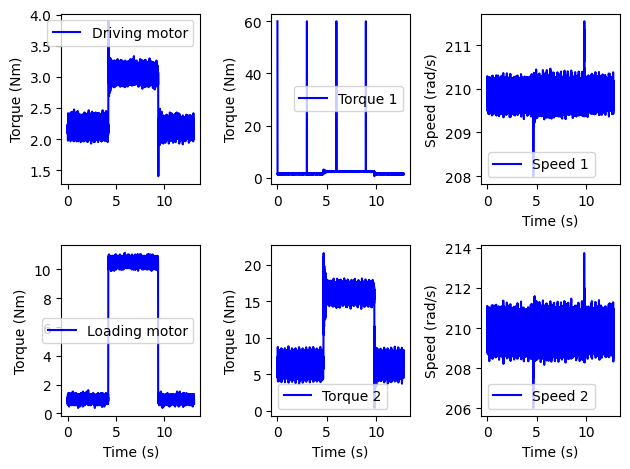

In [5]:
plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

## Initiate data and state-space model

In [6]:
time = sensor_data_step[:,0]
measurements = sensor_data_step[:,1:] # measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
motors = np.vstack((motor_data_step[:,2], motor_data_step[:,4])).T # motor torque data

In [7]:
dt = np.mean(np.diff(time))
A, B, C, D = get_testbench_state_space(dt)
ss = (A, B, C, D)

In [8]:
# include second torque transducer to the observation matrix
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4
D_mod = np.zeros((C_mod.shape[0], B.shape[1]))

In [9]:
# HP STEP
# measurement data from the encoder 1, encoder 2 and torque transducer 1 & 2
measurements_step = sensor_data_step[:,1:]
batch_size  = 200
OVERLAP     = 40

input_estimates_step = weighted_ell2_analytical(
    ss, measurements_step[:,:-1], batch_size, overlap=OVERLAP, lam=1, use_trend_filter=True
)

In [10]:
len(sensor_data_step[:,1:])

12867

In [11]:
motor_input_step_est, propeller_input_step_est = process_estimates(len(input_estimates_step), OVERLAP, input_estimates_step, nstates=0)

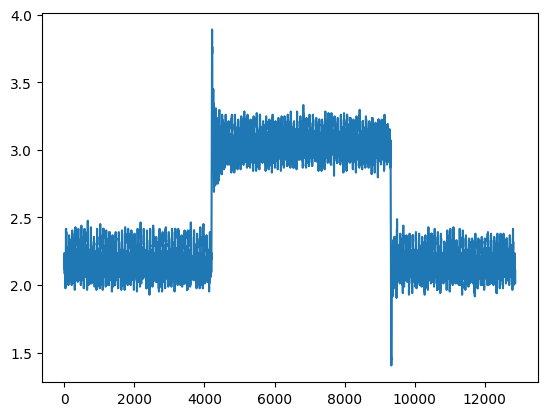

In [12]:
%matplotlib inline
# plt.plot(motor_input_step_est[100:])
plt.plot(motor_data_step[:,2])
plt.show()

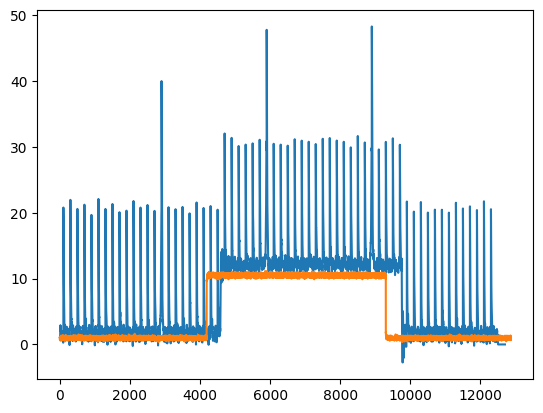

In [13]:
%matplotlib inline
plt.plot(propeller_input_step_est[100:])
plt.plot(motor_data_step[:,4])
plt.show()

## SVM input outlier filtering

In [14]:
# create bounds
lam = 0.01
eps = 0.01

svm_step_input_est = svm_reconstruction(
    ss, measurements_step[:,:-1], batch_size, overlap=OVERLAP, lam=lam, eps=eps, use_trend_filter=True
)

prob solved  0  y shape =  (840, 1)
prob solved  1  y shape =  (840, 1)
prob solved  2  y shape =  (840, 1)
prob solved  3  y shape =  (840, 1)
prob solved  4  y shape =  (840, 1)
prob solved  5  y shape =  (840, 1)
prob solved  6  y shape =  (840, 1)
prob solved  7  y shape =  (840, 1)
prob solved  8  y shape =  (840, 1)
prob solved  9  y shape =  (840, 1)
prob solved  10  y shape =  (840, 1)
prob solved  11  y shape =  (840, 1)
prob solved  12  y shape =  (840, 1)
prob solved  13  y shape =  (840, 1)
prob solved  14  y shape =  (840, 1)
prob solved  15  y shape =  (840, 1)
prob solved  16  y shape =  (840, 1)
prob solved  17  y shape =  (840, 1)
prob solved  18  y shape =  (840, 1)
prob solved  19  y shape =  (840, 1)
prob solved  20  y shape =  (840, 1)
prob solved  21  y shape =  (840, 1)
prob solved  22  y shape =  (840, 1)
prob solved  23  y shape =  (840, 1)
prob solved  24  y shape =  (840, 1)
prob solved  25  y shape =  (840, 1)
prob solved  26  y shape =  (840, 1)
prob solved

In [15]:
motor_input_svm, propeller_input_svm = process_estimates(len(svm_step_input_est), OVERLAP, svm_step_input_est, nstates=0)

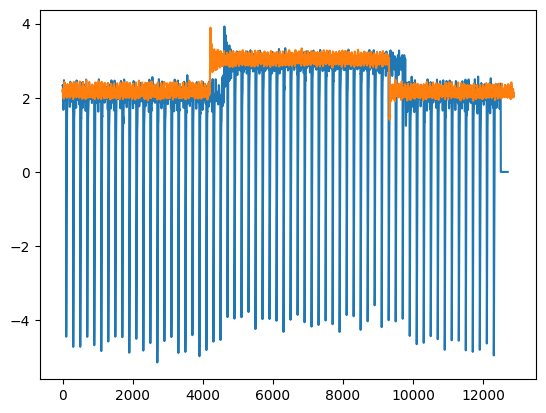

In [16]:
%matplotlib inline
plt.plot(motor_input_svm[100:])
plt.plot(motor_data_step[:,2])
plt.show()

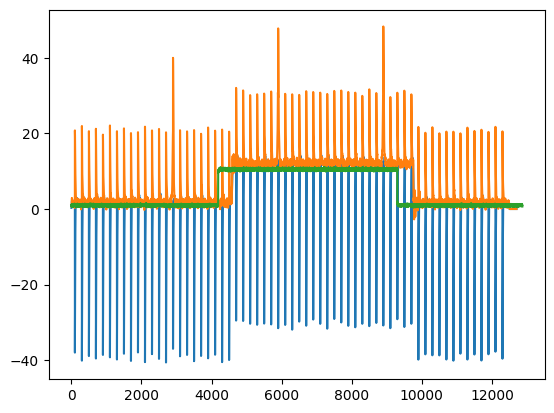

In [17]:
%matplotlib inline
plt.plot(propeller_input_svm[100:])
plt.plot(propeller_input_step_est[100:])
plt.plot(motor_data_step[:,4])
plt.show()

In [18]:
import pickle

with open('input_estimates_hp_svm.pkl', 'wb') as f:  # open a text file
    pickle.dump([motor_input_step_est, propeller_input_step_est, motor_input_svm, propeller_input_svm], f) # serialize the list
    
f.close()

In [19]:
with open('input_estimates_hp_svm.pkl', 'rb') as f:
    estimates_loaded = pickle.load(f) # deserialize using load()
motor_hp = estimates_loaded[0]
prop_hp = estimates_loaded[1]
motor_svm = estimates_loaded[2]
prop_svm = estimates_loaded[3]

In [20]:
U_est_hp = np.hstack((motor_hp, prop_hp))
U_est_svm = np.hstack((motor_svm, prop_svm))

In [21]:
time = sensor_data_step[:12500,0]
tout_hp, yout_hp, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_hp[:len(time), :], t=time)
tout_svm, yout_svm, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_svm[:len(time), :], t=time)

In [22]:
print("Time shape:", time.shape)
print("U_est_hp shape:", U_est_hp.shape)
print("U_est_svm shape:", U_est_svm.shape)


Time shape: (12500,)
U_est_hp shape: (12800, 2)
U_est_svm shape: (12800, 2)


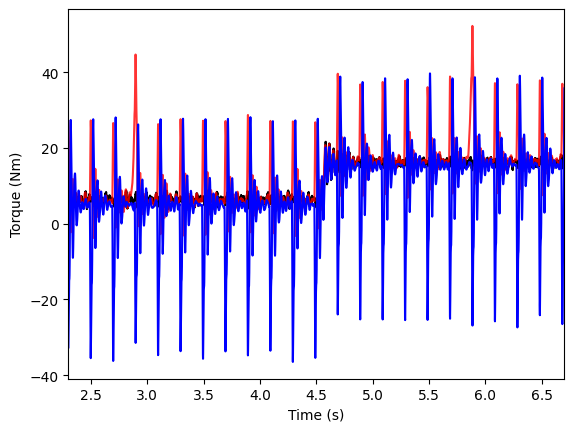

In [23]:
plt.plot(time[:-100], sensor_data_step[100:12500,4], 'k')
plt.plot(tout_hp[:-100], yout_hp[100:,-1], 'r-', alpha=0.8)
plt.plot(tout_svm[:-100], yout_svm[100:,-1], 'b-')
plt.xlim(2.3,6.7)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.show()